# Подготовка данных #

Всего комментариев: 2373

Первые 5 записей:
        id  rating                                       comment  \
0  2945792       5                                       спасибо   
1  3234340       5                                      спасибо!   
2  3380332       5                                      Отлично    
3  3381812       5  Благодарю за оперативное решение проблемы !    
4  3461991       5         Прекрасный специалист! Побольше таких   

   Нравится скорость отработки заявок  Нравится качество выполнения заявки  \
0                                 NaN                                  NaN   
1                                 NaN                                  NaN   
2                                 NaN                                  NaN   
3                                 NaN                                  NaN   
4                                 NaN                                  NaN   

   Нравится качество работы сотрудников  Понравилось выполнение заявки  \
0   

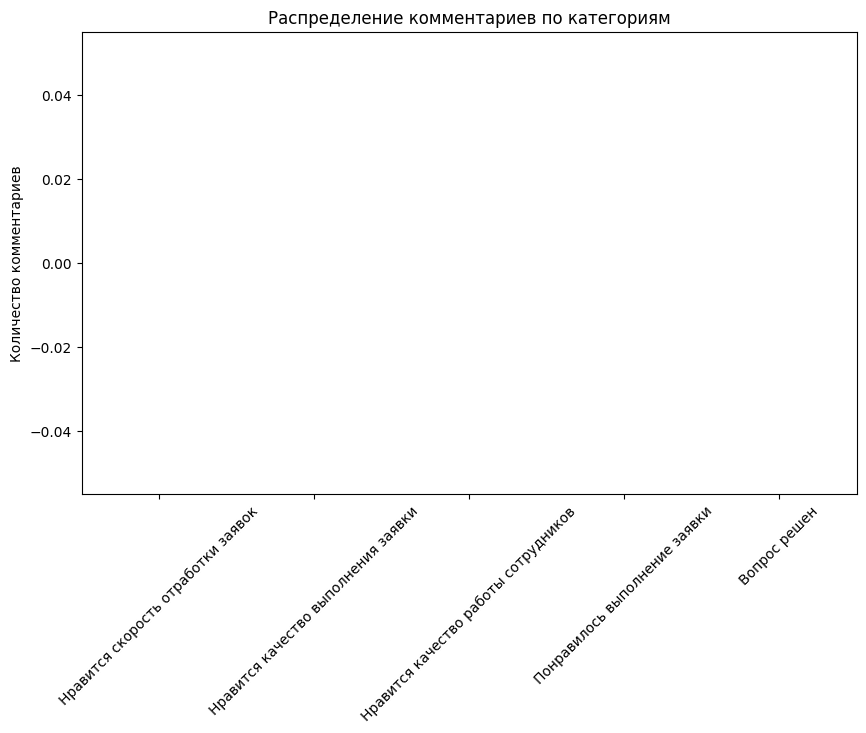

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

data = pd.read_csv('comments.csv')

# Предварительный анализ данных
print(f"Всего комментариев: {len(data)}")
print("\nПервые 5 записей:")
print(data.head())

print("\nИнформация о датасете:")
print(data.info())

print("\nСтатистика по классам:")
class_columns = ['Нравится скорость отработки заявок', 
                'Нравится качество выполнения заявки', 
                'Нравится качество работы сотрудников', 
                'Понравилось выполнение заявки', 
                'Вопрос решен']
print(data[class_columns].sum())

# Визуализация распределения классов
plt.figure(figsize=(10, 6))
data[class_columns].sum().plot(kind='bar')
plt.title('Распределение комментариев по категориям')
plt.ylabel('Количество комментариев')
plt.xticks(rotation=45)
plt.show()

# Разметка данных в Label Studio #

In [17]:
# Генерация конфигурации для Label Studio
label_config = """
<View>
  <Header value="Выберите категории, которые относятся к комментарию:"/>
  <Text name="text" value="$text"/>
  <Choices name="sentiment" toName="text" choice="multiple" showInLine="true">
    <Choice value="Нравится скорость отработки заявок"/>
    <Choice value="Нравится качество выполнения заявки"/>
    <Choice value="Нравится качество работы сотрудников"/>
    <Choice value="Понравилось выполнение заявки"/>
    <Choice value="Вопрос решен"/>
  </Choices>
</View>
"""

# Сохранение конфигурации в файл
with open('label_config.xml', 'w', encoding='utf-8') as f:
    f.write(label_config)

# Подготовка данных для импорта в Label Studio
label_studio_data = []
for idx, row in data.iterrows():
    label_studio_data.append({
        'data': {
            'text': row['comment']
        },
        'predictions': [{
            'result': [],
            'score': 0
        }]
    })

# Сохранение данных в JSON для импорта в Label Studio
import json
with open('comments_for_labeling.json', 'w', encoding='utf-8') as f:
    json.dump(label_studio_data, f, ensure_ascii=False, indent=2)

print("Файлы для Label Studio подготовлены:")
print("- label_config.xml - конфигурация интерфейса разметки")
print("- comments_for_labeling.json - данные для разметки")

Файлы для Label Studio подготовлены:
- label_config.xml - конфигурация интерфейса разметки
- comments_for_labeling.json - данные для разметки


# Обработка размеченных данных #


In [18]:
import json
import pandas as pd

def process_label_studio_export(export_file):
    with open(export_file, 'r', encoding='utf-8') as f:
        labeled_data = json.load(f)
    
    processed_data = []
    
    for item in labeled_data:
        # Проверяем, есть ли разметка для этого элемента
        if 'annotations' not in item or len(item['annotations']) == 0:
            continue
            
        text = item['data']['text']
        annotations = item['annotations'][0]
        
        # Инициализируем все категории как 0
        row = {
            'text': text,
            'Нравится скорость отработки заявок': 0,
            'Нравится качество выполнения заявки': 0,
            'Нравится качество работы сотрудников': 0,
            'Понравилось выполнение заявки': 0,
            'Вопрос решен': 0
        }
        
        # Обрабатываем все результаты аннотации
        for result in annotations['result']:
            if 'value' in result and 'choices' in result['value']:
                for choice in result['value']['choices']:
                    if choice in row:
                        row[choice] = 1
        
        processed_data.append(row)
    
    return pd.DataFrame(processed_data)

# Использование функции
labeled_df = process_label_studio_export('exported_labels.json')

# Сохранение в CSV
labeled_df.to_csv('labeled_comments_processed.csv', index=False, encoding='utf-8')

print(f"Успешно обработано {len(labeled_df)} комментариев")
print("\nРаспределение по категориям:")
print(labeled_df.drop(columns='text').sum())

Успешно обработано 282 комментариев

Распределение по категориям:
Нравится скорость отработки заявок       71
Нравится качество выполнения заявки      35
Нравится качество работы сотрудников     64
Понравилось выполнение заявки           149
Вопрос решен                             31
dtype: int64


# Построение модели классификации #


In [19]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import nltk
import warnings
import joblib

# Настройки
warnings.filterwarnings('ignore')
nltk.download('stopwords')

# Подготовка стоп-слов
russian_stop_words = stopwords.words('russian')
custom_stop_words = ['спасибо', 'благодарю', 'заявк', 'управляющ', 'компани', 'сдел', 'работ']
all_stop_words = russian_stop_words + custom_stop_words

# Загрузка данных
try:
    labeled_data = pd.read_csv('labeled_comments_processed.csv')
    print(f"Успешно загружено {len(labeled_data)} комментариев")
    
    class_columns = ['Нравится скорость отработки заявок', 
                   'Нравится качество выполнения заявки', 
                   'Нравится качество работы сотрудников', 
                   'Понравилось выполнение заявки', 
                   'Вопрос решен']
    
    # Проверка распределения классов
    class_distribution = labeled_data[class_columns].sum()
    print("\nРаспределение по классам:")
    print(class_distribution)
    
    # Фильтрация классов с недостаточным количеством примеров
    valid_columns = [col for col in class_columns if class_distribution[col] >= 2]
    if len(valid_columns) < len(class_columns):
        print(f"\nУдалены классы с недостаточным количеством примеров: {set(class_columns) - set(valid_columns)}")
        class_columns = valid_columns
    
    if not class_columns:
        raise ValueError("Нет классов с достаточным количеством примеров для обучения!")
        
except Exception as e:
    print(f"Ошибка загрузки данных: {e}")
    raise

# Подготовка данных
X = labeled_data['text']
y = labeled_data[class_columns]

# Разделение данных
try:
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
except ValueError:
    print("\nПредупреждение: невозможно использовать стратификацию. Использую обычное разделение.")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

# Создание и обучение пайплайна
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_features=5000,
        stop_words=all_stop_words,
        ngram_range=(1, 2),
        min_df=2
    )),
    ('clf', MultiOutputClassifier(
        RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced',
            random_state=42
        ),
        n_jobs=-1
    ))
])

print("\nОбучение модели...")
pipeline.fit(X_train, y_train)

# Оценка модели
y_pred = pipeline.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_columns))

# Вычисление ROC-AUC
print("\nROC-AUC scores:")
y_pred_proba = pipeline.predict_proba(X_test)
for i, class_name in enumerate(class_columns):
    try:
        if len(np.unique(y_test[class_name])) >= 2:
            auc = roc_auc_score(y_test[class_name], y_pred_proba[i][:, 1])
            print(f"{class_name}: {auc:.4f}")
    except Exception as e:
        print(f"{class_name}: ошибка вычисления - {str(e)}")

# Сохранение модели
joblib.dump(pipeline, 'comment_classifier.joblib')
print("\nМодель успешно сохранена в 'comment_classifier.joblib'")

Успешно загружено 282 комментариев

Распределение по классам:
Нравится скорость отработки заявок       71
Нравится качество выполнения заявки      35
Нравится качество работы сотрудников     64
Понравилось выполнение заявки           149
Вопрос решен                             31
dtype: int64

Предупреждение: невозможно использовать стратификацию. Использую обычное разделение.

Обучение модели...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Silv3\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!



Classification Report:
                                      precision    recall  f1-score   support

  Нравится скорость отработки заявок       0.85      0.79      0.81        14
 Нравится качество выполнения заявки       0.50      0.80      0.62         5
Нравится качество работы сотрудников       0.50      0.36      0.42        11
       Понравилось выполнение заявки       0.62      0.77      0.69        31
                        Вопрос решен       0.00      0.00      0.00         8

                           micro avg       0.61      0.62      0.62        69
                           macro avg       0.49      0.54      0.51        69
                        weighted avg       0.56      0.62      0.59        69
                         samples avg       0.62      0.63      0.60        69


ROC-AUC scores:
Нравится скорость отработки заявок: 0.8970
Нравится качество выполнения заявки: 0.8115
Нравится качество работы сотрудников: 0.5800
Понравилось выполнение заявки: 0.5695
Вопрос

# Анализ результатов и выводы #

In [20]:
# Анализ важности признаков
feature_importances = []
for i, class_name in enumerate(class_columns):
    importances = pipeline.named_steps['clf'].estimators_[i].feature_importances_
    feature_names = pipeline.named_steps['tfidf'].get_feature_names_out()
    feature_importances.append(pd.DataFrame({
        'feature': feature_names,
        'importance': importances,
        'class': class_name
    }))

# Объединение всех важностей
all_importances = pd.concat(feature_importances)

# Топ-10 важных слов для каждой категории
for class_name in class_columns:
    print(f"\nTop 10 features for {class_name}:")
    print(all_importances[all_importances['class'] == class_name]
          .sort_values('importance', ascending=False)
          .head(10)[['feature', 'importance']])


Top 10 features for Нравится скорость отработки заявок:
                  feature  importance
5                  быстро    0.237070
42             оперативно    0.179497
46          оперативность    0.085673
69                 работу    0.032235
2                 большое    0.025222
25            качественно    0.023152
59                 пришли    0.022980
14                    всё    0.021598
4   большое оперативность    0.017894
52                  очень    0.017273

Top 10 features for Нравится качество выполнения заявки:
        feature  importance
25  качественно    0.076922
2       большое    0.062180
90      сегодня    0.058519
28       мастер    0.052766
47        ответ    0.049613
96        стало    0.048108
5        быстро    0.045019
23       заявки    0.043174
67       работа    0.040012
21  закрывается    0.032661

Top 10 features for Нравится качество работы сотрудников:
       feature  importance
28      мастер    0.120536
98     татьяна    0.060457
29     мастеру    0

# Автоматическая классификация новых отзывов #


In [21]:
# Загрузка сохраненной модели
model = joblib.load('comment_classifier.joblib')

# Пример новых отзывов для классификации
new_comments = [
    "Мастер пришел быстро и все качественно починил",
    "Спасибо за решение проблемы",
    "Работа выполнена неаккуратно, пришлось переделывать",
    "Сотрудники вежливые и профессиональные"
]

# Предсказание для новых отзывов
predictions = model.predict(new_comments)
pred_proba = model.predict_proba(new_comments)

# Создаем DataFrame с результатами
results_df = pd.DataFrame({
    'Комментарий': new_comments,
    **{class_name: predictions[:, i] for i, class_name in enumerate(class_columns)},
    **{f'Вероятность_{class_name}': pred_proba[i][:, 1] for i, class_name in enumerate(class_columns)}
})

# Выводим красивые результаты
print("\nАвтоматическая классификация новых отзывов:")
display(results_df.style.background_gradient(cmap='Blues', subset=class_columns))


Автоматическая классификация новых отзывов:


,Комментарий,Нравится скорость отработки заявок,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Понравилось выполнение заявки,Вопрос решен,Вероятность_Нравится скорость отработки заявок,Вероятность_Нравится качество выполнения заявки,Вероятность_Нравится качество работы сотрудников,Вероятность_Понравилось выполнение заявки,Вероятность_Вопрос решен
0,Мастер пришел быстро и все качественно починил,1,1,1,0,0,0.900000,0.697480,0.700000,0.050000,0.000000
1,Спасибо за решение проблемы,0,0,0,0,0,0.309304,0.280033,0.314126,0.488003,0.397372
2,"Работа выполнена неаккуратно, пришлось переделывать",0,1,0,1,0,0.075827,0.521734,0.222521,0.785529,0.099315
3,Сотрудники вежливые и профессиональные,0,0,0,1,0,0.043816,0.093223,0.258316,0.787098,0.354350


# Визуализация результатов #


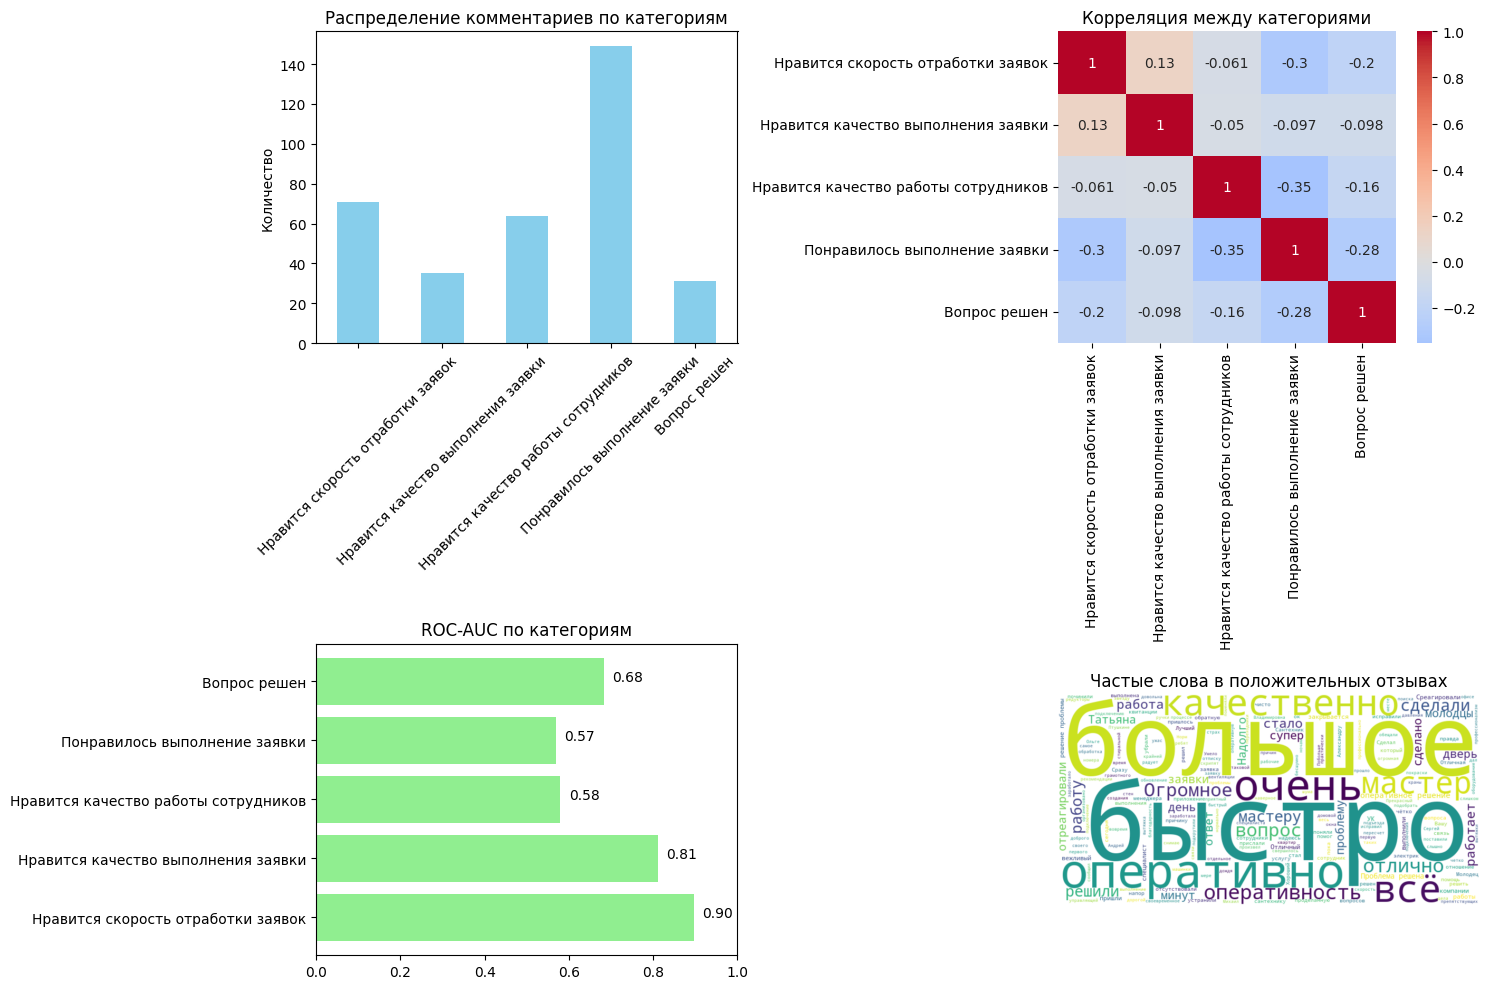

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.metrics import roc_auc_score
import numpy as np

plt.figure(figsize=(15, 10))

# 1. Распределение классов
plt.subplot(2, 2, 1)
y.sum().plot(kind='bar', color='skyblue')
plt.title('Распределение комментариев по категориям')
plt.ylabel('Количество')
plt.xticks(rotation=45)

# 2. Матрица корреляций между категориями
plt.subplot(2, 2, 2)
sns.heatmap(y.corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Корреляция между категориями')

# 3. ROC-AUC для каждой категории (с обработкой ошибок)
plt.subplot(2, 2, 3)
auc_scores = []
for i, col in enumerate(class_columns):
    try:
        # Проверяем, что в тестовых данных есть оба класса
        if len(np.unique(y_test[col])) == 2:
            auc = roc_auc_score(y_test[col], model.predict_proba(X_test)[i][:, 1])
            auc_scores.append(auc)
        else:
            auc_scores.append(np.nan)
    except Exception as e:
        print(f"Ошибка расчета ROC-AUC для '{col}': {str(e)}")
        auc_scores.append(np.nan)

valid_auc = [x for x in auc_scores if not np.isnan(x)]
valid_labels = [class_columns[i] for i, x in enumerate(auc_scores) if not np.isnan(x)]

if len(valid_auc) > 0:
    plt.barh(valid_labels, valid_auc, color='lightgreen')
    plt.title('ROC-AUC по категориям')
    plt.xlim(0, 1)
    for i, v in enumerate(valid_auc):
        plt.text(v + 0.02, i, f"{v:.2f}", color='black')
else:
    plt.text(0.5, 0.5, 'Не удалось рассчитать ROC-AUC\nдля каких-либо категорий', 
             ha='center', va='center')
    plt.title('ROC-AUC недоступен')

# 4. Облако слов для положительных отзывов
plt.subplot(2, 2, 4)
positive_mask = (y.sum(axis=1) > 0)
if sum(positive_mask) > 0:
    all_positive_text = ' '.join(X[positive_mask])
    wordcloud = WordCloud(width=800, height=400, 
                         background_color='white',
                         stopwords=all_stop_words).generate(all_positive_text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title('Частые слова в положительных отзывах')
else:
    plt.text(0.5, 0.5, 'Нет положительных отзывов\nдля анализа', 
             ha='center', va='center')
    plt.title('Облако слов недоступно')
plt.axis('off')

plt.tight_layout()
plt.show()

# Дополнительная визуализация метрик модели #

C:\Users\Silv3\AppData\Local\Temp\ipykernel_27644\3649205411.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis')
C:\Users\Silv3\AppData\Local\Temp\ipykernel_27644\3649205411.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='rocket')


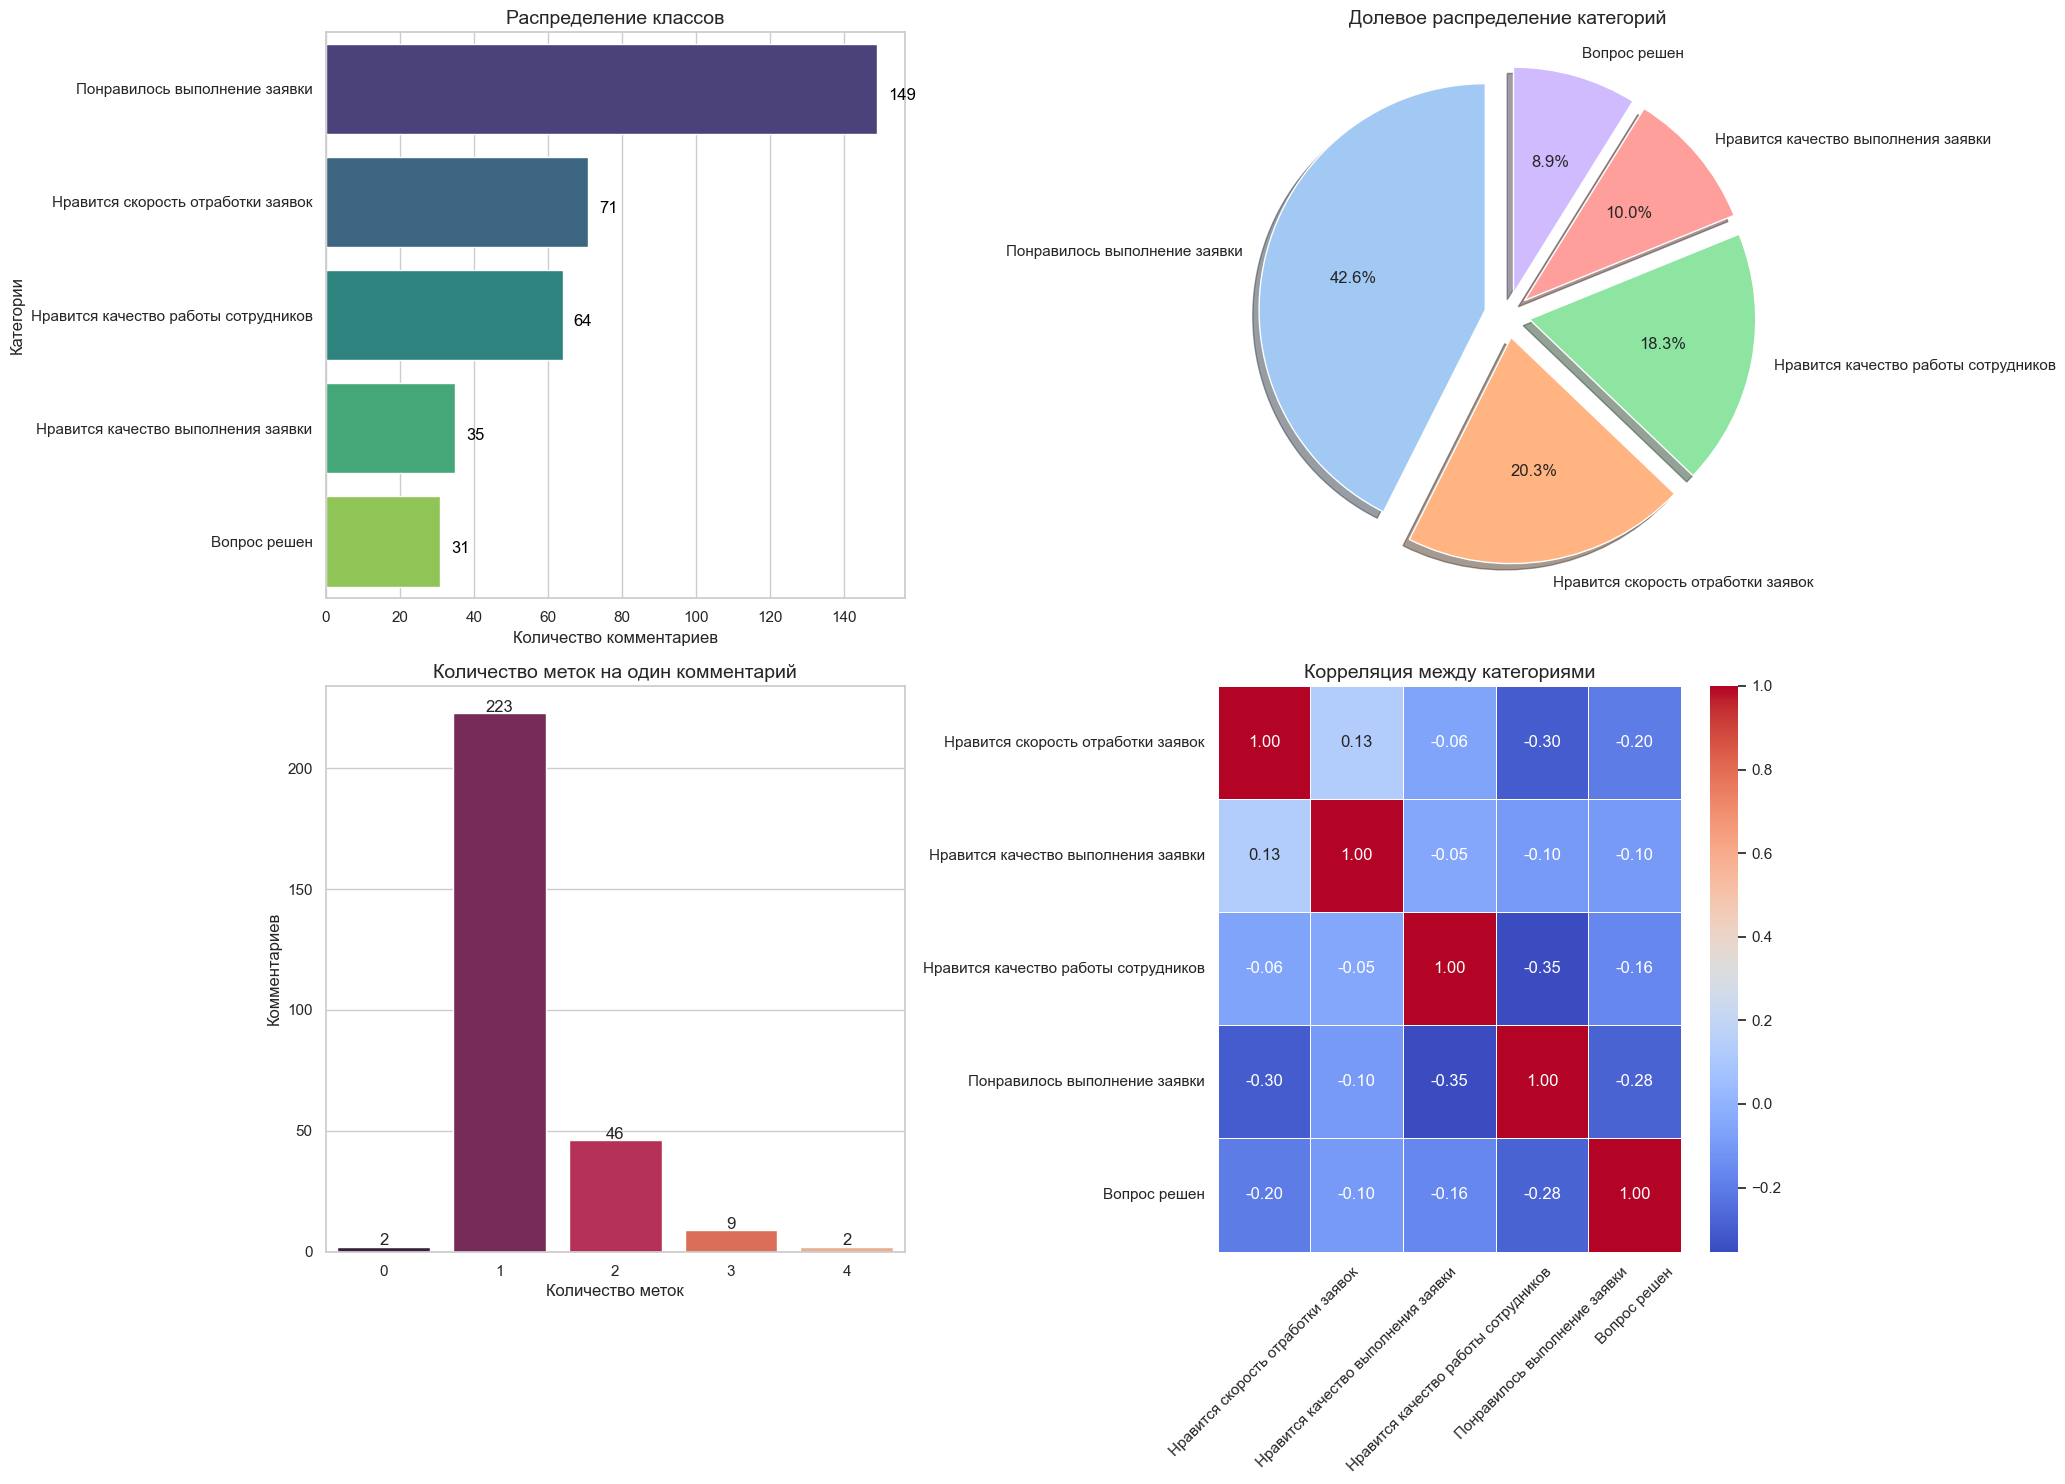

c:\Users\Silv3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Silv3\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Silv3\AppData\Local\Temp\ipykernel_27644\3649205411.py:126: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1-score', y='Model', data=resu

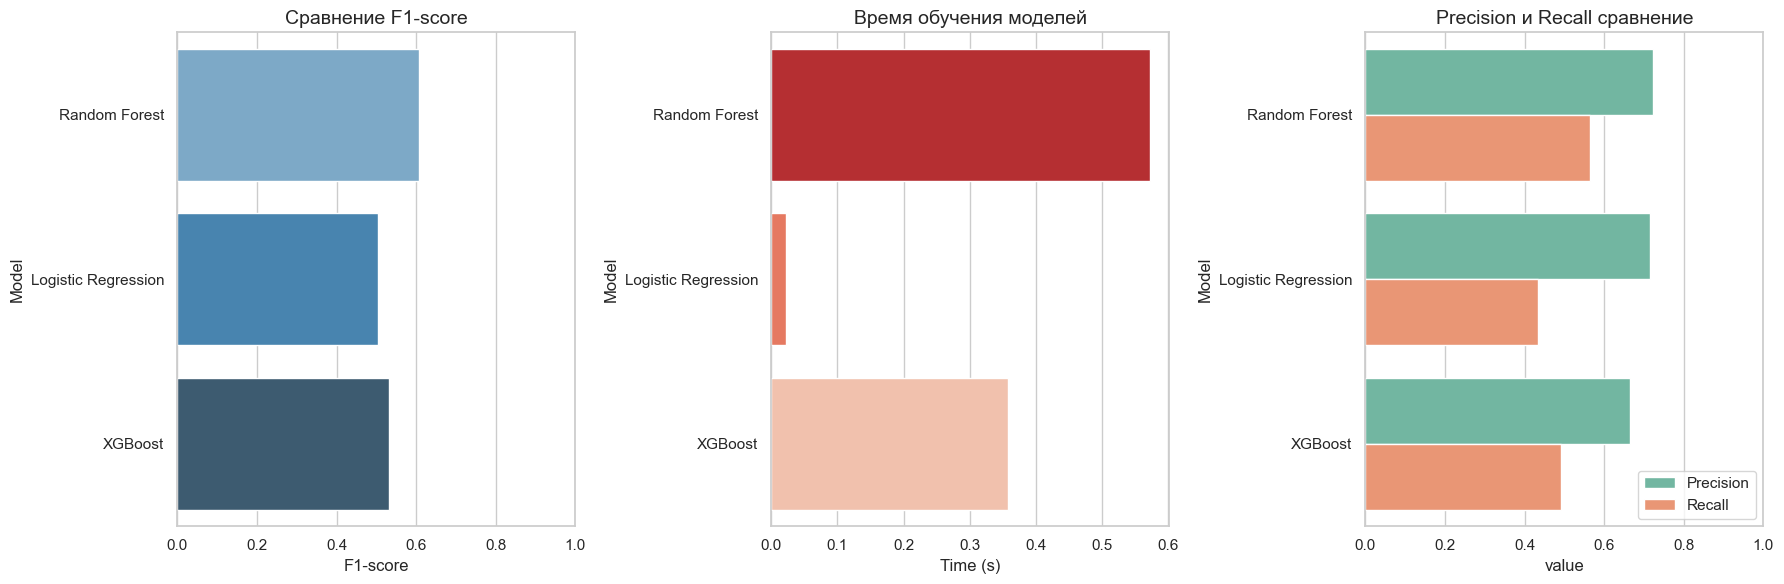

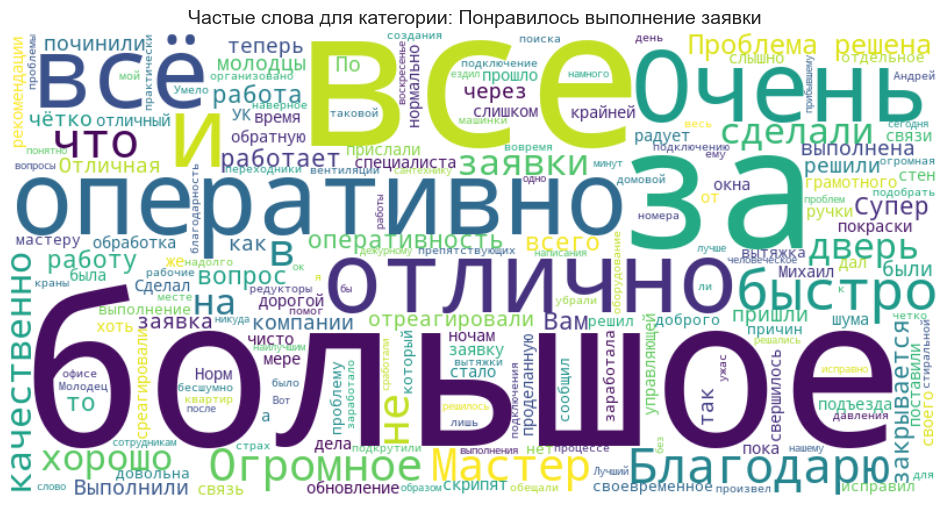

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import time

# Загрузка данных
data = pd.read_csv('labeled_comments_processed.csv')

# =============================================
# Анализ распределения классов
# =============================================
plt.figure(figsize=(20, 15))

# График 1: Распределение классов
plt.subplot(2, 2, 1)
class_columns = data.columns[1:]
class_counts = data[class_columns].sum().sort_values(ascending=False)
ax = sns.barplot(x=class_counts.values, y=class_counts.index, palette='viridis')
plt.title('Распределение классов', fontsize=14)
plt.xlabel('Количество комментариев')
plt.ylabel('Категории')
for i, v in enumerate(class_counts):
    ax.text(v + 3, i + 0.1, str(v), color='black')

# График 2: Круговая диаграмма
plt.subplot(2, 2, 2)
explode = [0.1] * len(class_counts)
plt.pie(class_counts, 
        labels=class_counts.index,
        autopct='%1.1f%%',
        startangle=90,
        shadow=True,
        explode=explode,
        colors=sns.color_palette('pastel'))
plt.title('Долевое распределение категорий', fontsize=14)

# График 3: Распределение количества меток
plt.subplot(2, 2, 3)
label_counts = data[class_columns].sum(axis=1).value_counts().sort_index()
sns.barplot(x=label_counts.index, y=label_counts.values, palette='rocket')
plt.title('Количество меток на один комментарий', fontsize=14)
plt.xlabel('Количество меток')
plt.ylabel('Комментариев')
for i, v in enumerate(label_counts):
    plt.text(i, v + 0.5, str(v), ha='center')

# График 4: Матрица корреляций
plt.subplot(2, 2, 4)
corr_matrix = data[class_columns].corr()
sns.heatmap(corr_matrix, 
           annot=True, 
           cmap='coolwarm', 
           fmt=".2f",
           linewidths=0.5)
plt.title('Корреляция между категориями', fontsize=14)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# =============================================
# Сравнение моделей
# =============================================
# Подготовка данных
X = data['text']
y = data[class_columns]

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Настройки для моделей
models = {
    'Random Forest': MultiOutputClassifier(RandomForestClassifier(n_estimators=100)),
    'Logistic Regression': MultiOutputClassifier(LogisticRegression(max_iter=1000)),
    'XGBoost': MultiOutputClassifier(XGBClassifier())
}

# Обучение и оценка моделей
results = []
vectorizer = TfidfVectorizer(max_features=5000)

for name, model in models.items():
    start_time = time.time()
    
    # Преобразование текста
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    # Обучение модели
    model.fit(X_train_vec, y_train)
    
    # Предсказания
    y_pred = model.predict(X_test_vec)
    
    # Расчет метрик
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    train_time = time.time() - start_time
    
    results.append({
        'Model': name,
        'F1-score': f1,
        'Precision': precision,
        'Recall': recall,
        'Time (s)': train_time
    })

# Создание DataFrame с результатами
results_df = pd.DataFrame(results)

# Визуализация сравнения моделей
plt.figure(figsize=(18, 6))

# График 1: Сравнение F1-score
plt.subplot(1, 3, 1)
sns.barplot(x='F1-score', y='Model', data=results_df, palette='Blues_d')
plt.title('Сравнение F1-score', fontsize=14)
plt.xlim(0, 1)

# График 2: Сравнение времени обучения
plt.subplot(1, 3, 2)
sns.barplot(x='Time (s)', y='Model', data=results_df, palette='Reds_r')
plt.title('Время обучения моделей', fontsize=14)

# График 3: Precision-Recall сравнение
plt.subplot(1, 3, 3)
results_df_melted = results_df.melt(id_vars='Model', 
                                  value_vars=['Precision', 'Recall'],
                                  var_name='Metric')
sns.barplot(x='value', y='Model', hue='Metric', data=results_df_melted, palette='Set2')
plt.title('Precision и Recall сравнение', fontsize=14)
plt.xlim(0, 1)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

# =============================================
# Дополнительная визуализация
# =============================================
# Облако слов для наиболее частых категорий
plt.figure(figsize=(12, 8))
most_common_class = class_counts.idxmax()
positive_text = ' '.join(data[data[most_common_class] == 1]['text'])
wordcloud = WordCloud(width=800, 
                     height=400, 
                     background_color='white',
                     stopwords=['спасибо', 'заявк', 'сдела']).generate(positive_text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Частые слова для категории: {most_common_class}', fontsize=14)
plt.axis('off')
plt.show()

# Анализ важности признаков #
 

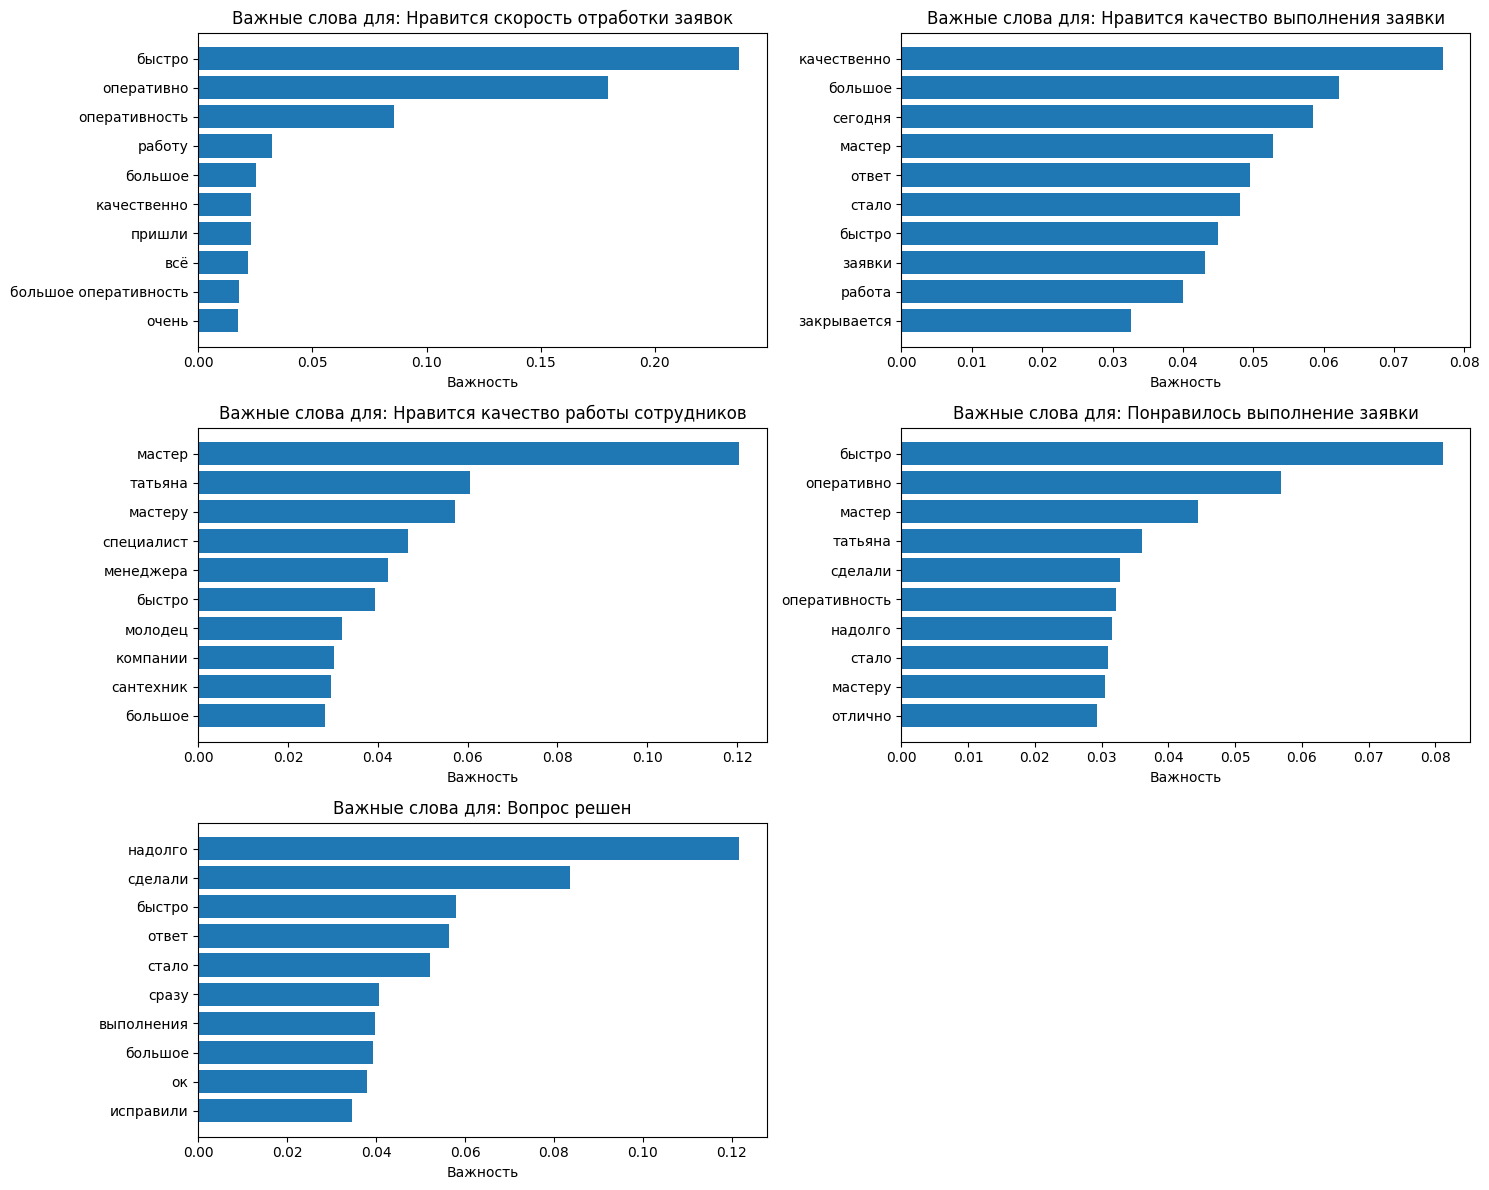

In [23]:
# Получаем важные слова для каждой категории
feature_names = model.named_steps['tfidf'].get_feature_names_out()

plt.figure(figsize=(15, 12))
for i, category in enumerate(class_columns):
    plt.subplot(3, 2, i+1)
    importances = model.named_steps['clf'].estimators_[i].feature_importances_
    top_idx = np.argsort(importances)[-10:]
    plt.barh(feature_names[top_idx], importances[top_idx])
    plt.title(f'Важные слова для: {category}')
    plt.xlabel('Важность')

plt.tight_layout()
plt.show()

# Генерация отчета о работе #


In [24]:
from sklearn.metrics import precision_recall_fscore_support

# Создаем отчет
report = classification_report(y_test, y_pred, 
                             target_names=class_columns,
                             output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Сохраняем все результаты в один файл
with pd.ExcelWriter('classification_report.xlsx') as writer:
    results_df.to_excel(writer, sheet_name='Новые предсказания')
    report_df.to_excel(writer, sheet_name='Метрики модели')
    y.sum().to_frame('Количество').to_excel(writer, sheet_name='Распределение классов')
    
print("Полный отчет сохранен в файл 'classification_report.xlsx'")

Полный отчет сохранен в файл 'classification_report.xlsx'


# Финальный скрипт для автоматизации #
 

In [25]:
def classify_new_comment(comment):
    """Функция для классификации одного комментария"""
    proba = model.predict_proba([comment])
    result = {
        'Комментарий': comment,
        **{class_col: model.predict([comment])[0][i] 
          for i, class_col in enumerate(class_columns)},
        **{f'Вероятность_{class_col}': float(proba[i][0][1]) 
          for i, class_col in enumerate(class_columns)}
    }
    return result

# Пример использования
sample_comment = "Быстро ответили на заявку и профессионально устранили проблему"
classification_result = classify_new_comment(sample_comment)
print("\nРезультат классификации для комментария:")
print(f"'{sample_comment}'")
for k, v in classification_result.items():
    if k.startswith('Вероятность') and v > 0.5:
        print(f"{k.replace('Вероятность_', '')}: {v:.2f}")


Результат классификации для комментария:
'Быстро ответили на заявку и профессионально устранили проблему'
Нравится скорость отработки заявок: 0.84


In [28]:
import pandas as pd
import joblib
from tqdm import tqdm  # для прогресс-бара

# Загрузка модели и данных
model = joblib.load('comment_classifier.joblib')
comments_df = pd.read_csv('comments.csv')  # исходные данные
output_file = 'classified_comments.csv'  # файл для сохранения результатов

# Функция для классификации и сохранения результатов
def classify_and_save_comments(input_df, output_path, model):
    # Создаем копию DataFrame для результатов
    result_df = input_df.copy()
    
    # Добавляем колонки для категорий, если их нет
    class_columns = ['Нравится скорость отработки заявок',
                    'Нравится качество выполнения заявки',
                    'Нравится качество работы сотрудников',
                    'Понравилось выполнение заявки',
                    'Вопрос решен']
    
    for col in class_columns:
        if col not in result_df.columns:
            result_df[col] = 0
    
    # Классифицируем каждый комментарий
    for idx, row in tqdm(result_df.iterrows(), total=len(result_df), desc="Классификация"):
        comment = row['comment']
        if pd.isna(comment):
            continue
        
        # Получаем предсказания
        prediction = model.predict([comment])[0]
        probabilities = model.predict_proba([comment])
        
        # Записываем результаты
        for i, col in enumerate(class_columns):
            result_df.at[idx, col] = prediction[i]
            result_df.at[idx, f'Вероятность_{col}'] = probabilities[i][0][1]
    
    # Сохраняем в новый файл
    result_df.to_csv(output_path, index=False, encoding='utf-8-sig')
    return result_df

# Запускаем классификацию
classified_df = classify_and_save_comments(comments_df, output_file, model)

# Выводим статистику
print("\nРезультаты классификации:")
print(f"Всего комментариев: {len(classified_df)}")
print("Распределение по категориям:")
for col in class_columns:
    count = classified_df[col].sum()
    print(f"- {col}: {count} ({count/len(classified_df):.1%})")

# Пример вывода первых 5 строк
print("\nПример классифицированных комментариев:")
display(classified_df.head())

Классификация: 100%|██████████| 2373/2373 [02:50<00:00, 13.90it/s]


Результаты классификации:
Всего комментариев: 2373
Распределение по категориям:
- Нравится скорость отработки заявок: 726.0 (30.6%)
- Нравится качество выполнения заявки: 182.0 (7.7%)
- Нравится качество работы сотрудников: 292.0 (12.3%)
- Понравилось выполнение заявки: 1482.0 (62.5%)
- Вопрос решен: 78.0 (3.3%)

Пример классифицированных комментариев:


,id,rating,comment,Нравится скорость отработки заявок,Нравится качество выполнения заявки,Нравится качество работы сотрудников,Понравилось выполнение заявки,Вопрос решен,Вероятность_Нравится скорость отработки заявок,Вероятность_Нравится качество выполнения заявки,Вероятность_Нравится качество работы сотрудников,Вероятность_Понравилось выполнение заявки,Вероятность_Вопрос решен
0,2945792,5,спасибо,0.0,0.0,0.0,1.0,0.0,0.043816,0.093223,0.258316,0.787098,0.354350
1,3234340,5,спасибо!,0.0,0.0,0.0,1.0,0.0,0.043816,0.093223,0.258316,0.787098,0.354350
2,3380332,5,Отлично,0.0,0.0,0.0,1.0,0.0,0.000000,0.384352,0.001950,1.000000,0.004440
3,3381812,5,Благодарю за оперативное решение проблемы !,0.0,1.0,0.0,0.0,1.0,0.456603,0.501872,0.000000,0.000000,0.561294
4,3461991,5,Прекрасный специалист! Побольше таких,0.0,0.0,1.0,0.0,0.0,0.005900,0.008858,0.900215,0.103604,0.065659


# Telegram бот для классификации комментариев #

In [3]:
import telebot
from telebot import types
import joblib
import pandas as pd

# Загрузка обученной модели
try:
    model = joblib.load('comment_classifier.joblib')
    class_columns = ['Нравится скорость отработки заявок', 
                   'Нравится качество выполнения заявки', 
                   'Нравится качество работы сотрудников', 
                   'Понравилось выполнение заявки', 
                   'Вопрос решен']
    print("Модель успешно загружена")
except Exception as e:
    print(f"Ошибка загрузки модели: {e}")
    raise

# Инициализация бота
TOKEN = '7525825286:AAHtO4wKHUg3SHFSov40MZi1kUlkR-Fq300'  # Замените на ваш токен
bot = telebot.TeleBot(TOKEN)

# Обработчик команды /start
@bot.message_handler(commands=['start'])
def send_welcome(message):
    welcome_text = """
    Привет! Я бот для классификации комментариев о работе управляющей компании.
    
    Просто отправьте мне ваш комментарий, и я определю, к каким категориям он относится:
    - Нравится скорость отработки заявок
    - Нравится качество выполнения заявки
    - Нравится качество работы сотрудников
    - Понравилось выполнение заявки
    - Вопрос решен
    
    Пример комментария: "Мастер пришел быстро и все качественно починил"
    """
    bot.reply_to(message, welcome_text)

# Обработчик текстовых сообщений
@bot.message_handler(func=lambda message: True)
def classify_comment(message):
    try:
        comment = message.text
        
        # Получаем предсказания модели
        prediction = model.predict([comment])[0]
        probabilities = model.predict_proba([comment])
        
        # Формируем ответ
        response = f"Комментарий: \"{comment}\"\n\nКатегории:\n"
        
        # Собираем все вероятности в список
        all_probs = [probabilities[i][0][1] for i in range(len(class_columns))]
        
        has_positive = False
        for i, col in enumerate(class_columns):
            prob = probabilities[i][0][1]
            if prob > 0.5:  # Показываем только категории с вероятностью > 50%
                response += f"✅ {col}: {prob:.1%}\n"
                has_positive = True
        
        if not has_positive:
            response += "Не удалось однозначно определить категории (все вероятности ≤ 50%)"
        
        bot.reply_to(message, response)
        
    except Exception as e:
        bot.reply_to(message, f"Произошла ошибка при обработке комментария: {str(e)}")

# Запуск бота
print("Бот запущен...")
bot.polling()

Модель успешно загружена
Бот запущен...
